# CS448 - Lab 4: 3D Audio


In this lab we will learn how to create 3D sounds for headphone playback. We will make use of simple filters and HRTFs to create static and moving sources. Use the three sounds fly.wav, helicopter.wav, and crumble.wav in the lab archive as sources for the 3D recording that you will create.

In [17]:
### RUNNING VARIABLES ###

PLOT_GRAPHS = True
SUBMISSION_MODE = True

In [18]:
### IMPORTS & SETUP ###

import matplotlib.pyplot as plt

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (4, 3)

import numpy as np
from scipy.io import wavfile
from scipy.signal import convolve

# Importing the HRTF functions
# referencing https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
import sys
sys.path.append("./hrtf")
from load_hrtf import load_hrtf as hrtf_filter  # I modified this file to change the location of the numpy import

In [19]:
### UTILITIES ###


# Sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound(x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display(
        HTML('<style> table, th, td {border: 0px; }</style> <table><tr><td>' +
             label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:] +
             '</td></tr></table>'))


# Function that normalizes a signal
def normalize_signal(x):
    return x / np.max(np.abs(x))


# Function that plots the spectrogram of a sound
def plot_spectrogram(input_sound, fs, title="Spectrogram"):
    plt.title(title)
    plt.specgram(input_sound, Fs=fs, cmap="winter")
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')
    plt.show()

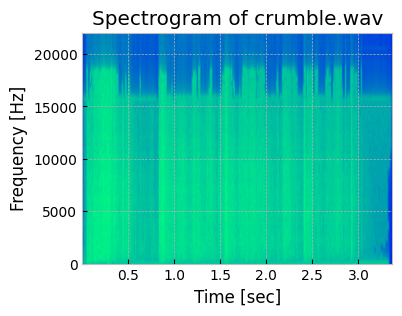

In [20]:
# Load the input sounds
fname_crumble = "crumble.wav"
fs_crumble, input_sound_crumble = wavfile.read(f"./data/{fname_crumble}")
input_sound_crumble = normalize_signal(input_sound_crumble)
sound(input_sound_crumble, rate=fs_crumble, label=fname_crumble)

if PLOT_GRAPHS:
    plot_spectrogram(input_sound_crumble,
                     fs_crumble,
                     title=f"Spectrogram of {fname_crumble}")

if not (SUBMISSION_MODE):
    fname_fly = "fly.wav"
    fs_fly, input_sound_fly = wavfile.read(f"./data/{fname_fly}")
    input_sound_fly = normalize_signal(input_sound_fly)
    sound(input_sound_fly, rate=fs_fly, label=fname_fly)

    fname_heli = "helicopter.wav"
    fs_heli, input_sound_heli = wavfile.read(f"./data/{fname_heli}")
    input_sound_heli = normalize_signal(input_sound_heli)
    sound(input_sound_heli, rate=fs_heli, label=fname_heli)

    if PLOT_GRAPHS:
        plot_spectrogram(input_sound_fly,
                         fs_fly,
                         title=f"Spectrogram of {fname_fly}")

        plot_spectrogram(input_sound_heli,
                         fs_heli,
                         title=f"Spectrogram of {fname_heli}")

## Part 1: Static sources using ITD/ILD cues

Assume the following source locations: 

- Straight ahead

- 45 degrees to the left

- 80 degrees to the right

- 160 degrees to the left

For each location find the source’s delay between the two ears (assume a source distance of 2 meters), and design two filters that will simulate that ITD and ILD features (feel free to round the IDT delays to an integer sample size). Assume that when sounds come from the side of the head the attenuation at the contralateral ear is by a factor of 0.7. From sounds coming medial plane (between the ears) there will be no attenuation due to the head. For positions moving from the medial plane towards the sides you can interpolate between no attenuation and a factor of 0.7. Design and plot the filters that correspond to the locations shown above and use them to make 3D sounds with the following sounds:

- Crumbling paper: [https://drive.google.com/uc?export=download&id=1bsZArYwMftsuCLdMknRomz4kAJWT-Uhv ]

- Fly: [https://drive.google.com/uc?export=download&id=1bswUsI28yJOUQuNLvNxq3pu9qj0bb8ne ]

- Helicopter: [https://drive.google.com/uc?export=download&id=1c8YhNNLmaO7CA2dJNCkBsB9MY0HjHDRL ]

Listen to the result through headphones and verify that they sound somewhat localized (it won’t sound perfect, but it should be believable).  There is no need to render all three sounds, since the notebook will become very large and hard to upload.  At submission time just render one sound, but make sure that you listen to all three and that they sound good.

In [21]:
# Constants
speed_of_sound = 343  # m/s
attenuation_factor = 0.7  # 1/m
source_distance = 2  # m
head_width = 0.2  # m

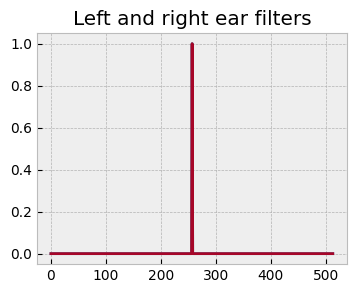

In [22]:
# Straight ahead
def straight_ahead(input_sound, fs):
    # Calculating the distance from the left and right ears
    dist_from_l_ear = np.sqrt(source_distance**2 + (head_width / 2)**2)
    dist_from_r_ear = np.sqrt(source_distance**2 + (head_width / 2)**2)

    # Calculating the delay for the left and right ears
    delay_l_ear = int(dist_from_l_ear / speed_of_sound * fs)
    delay_r_ear = int(dist_from_r_ear / speed_of_sound * fs)

    # Setting up the left and right ear filters
    l_ear_filter = np.zeros(delay_l_ear * 2)
    r_ear_filter = np.zeros(delay_r_ear * 2)

    l_ear_filter[delay_l_ear] = 1
    r_ear_filter[delay_r_ear] = 1

    l_chan = convolve(input_sound, l_ear_filter)
    r_chan = convolve(input_sound, r_ear_filter)

    if PLOT_GRAPHS:
        plt.figure()
        plt.title("Left and right ear filters")
        plt.plot(l_ear_filter)
        plt.plot(r_ear_filter)

    return np.vstack((l_chan, r_chan))


straight_ahead_crumble = straight_ahead(input_sound_crumble, fs_crumble)
sound(straight_ahead_crumble,
      rate=fs_crumble,
      label=f"{fname_crumble} straight ahead")

if not SUBMISSION_MODE:
    straight_ahead_fly = straight_ahead(input_sound_fly, fs_fly)
    sound(straight_ahead_fly, rate=fs_fly, label=f"{fname_fly} straight ahead")

    straight_ahead_heli = straight_ahead(input_sound_heli, fs_heli)
    sound(straight_ahead_heli,
          rate=fs_heli,
          label=f"{fname_heli} straight ahead")

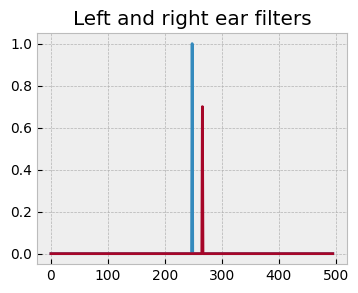

In [23]:
# 45° to the left
def left_45(input_sound, fs):
    radians = np.deg2rad(45)

    # Calculating the distance from the left and right ears
    dist_from_r_ear = np.sqrt((source_distance * np.cos(radians))**2 +
                              (source_distance * np.sin(radians) +
                               head_width / 2)**2)
    dist_from_l_ear = np.sqrt((source_distance * np.cos(radians))**2 +
                              (source_distance * np.sin(radians) -
                               head_width / 2)**2)

    # Calculating the delay for the left and right ears
    delay_l_ear = int(dist_from_l_ear / speed_of_sound * fs)
    delay_r_ear = int(dist_from_r_ear / speed_of_sound * fs)

    # Setting up the left and right ear filters
    l_ear_filter = np.zeros(delay_l_ear * 2)
    r_ear_filter = np.zeros(delay_l_ear *
                            2)  # Using delay_l_ear for same size arrays

    # Attenuating the filters
    l_ear_filter[delay_l_ear] = 1
    r_ear_filter[delay_r_ear] = attenuation_factor

    l_chan = convolve(input_sound, l_ear_filter)
    r_chan = convolve(input_sound, r_ear_filter)

    if PLOT_GRAPHS:
        plt.figure()
        plt.title("Left and right ear filters")
        plt.plot(l_ear_filter)
        plt.plot(r_ear_filter)

    return np.vstack((l_chan, r_chan))


left_45_crumble = left_45(input_sound_crumble, fs_crumble)
sound(left_45_crumble, rate=fs_crumble, label=f"{fname_crumble} 45° left")

if not SUBMISSION_MODE:
    left_45_fly = left_45(input_sound_fly, fs_fly)
    sound(left_45_fly, rate=fs_fly, label=f"{fname_fly} 45° left")

    left_45_heli = left_45(input_sound_heli, fs_heli)
    sound(left_45_heli, rate=fs_heli, label=f"{fname_heli} 45° left")

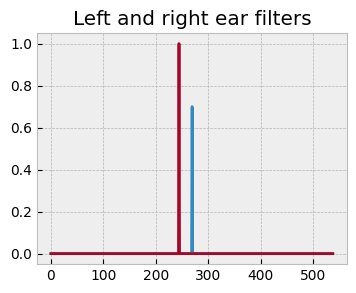

In [24]:
# 80° to the right
def right_80(input_sound, fs):
    radians = np.deg2rad(80)

    # Calculating the distance from the left and right ears
    dist_from_r_ear = np.sqrt((source_distance * np.cos(radians))**2 +
                              (source_distance * np.sin(radians) -
                               head_width / 2)**2)
    dist_from_l_ear = np.sqrt((source_distance * np.cos(radians))**2 +
                              (source_distance * np.sin(radians) +
                               head_width / 2)**2)

    # Calculating the delay for the left and right ears
    delay_l_ear = int(dist_from_l_ear / speed_of_sound * fs)
    delay_r_ear = int(dist_from_r_ear / speed_of_sound * fs)

    # Setting up the left and right ear filters
    l_ear_filter = np.zeros(delay_l_ear * 2)
    r_ear_filter = np.zeros(delay_l_ear *
                            2)  # Using delay_l_ear for same size arrays

    # Attenuating the filters
    l_ear_filter[delay_l_ear] = attenuation_factor
    r_ear_filter[delay_r_ear] = 1

    l_chan = convolve(input_sound, l_ear_filter)
    r_chan = convolve(input_sound, r_ear_filter)

    if PLOT_GRAPHS:
        plt.figure()
        plt.title("Left and right ear filters")
        plt.plot(l_ear_filter)
        plt.plot(r_ear_filter)

    return np.vstack((l_chan, r_chan))


right_80_crumble = right_80(input_sound_crumble, fs_crumble)
sound(right_80_crumble, rate=fs_crumble, label=f"{fname_crumble} 80° right")

if not SUBMISSION_MODE:
    right_80_fly = left_45(input_sound_fly, fs_fly)
    sound(right_80_fly, rate=fs_fly, label=f"{fname_fly} 80° right")

    right_80_heli = left_45(input_sound_heli, fs_heli)
    sound(right_80_heli, rate=fs_heli, label=f"{fname_heli} 80° right")

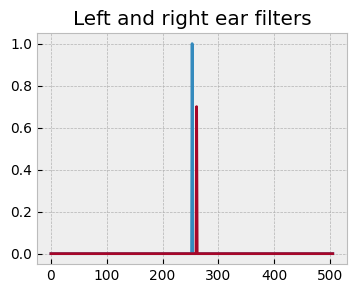

In [25]:
# 160° to the left
def left_160(input_sound, fs):
    radians = np.deg2rad(160)

    # Calculating the distance from the left and right ears
    dist_from_r_ear = np.sqrt((source_distance * np.cos(radians))**2 +
                              (source_distance * np.sin(radians) +
                               head_width / 2)**2)
    dist_from_l_ear = np.sqrt((source_distance * np.cos(radians))**2 +
                              (source_distance * np.sin(radians) -
                               head_width / 2)**2)

    # Calculating the delay for the left and right ears
    delay_l_ear = int(dist_from_l_ear / speed_of_sound * fs)
    delay_r_ear = int(dist_from_r_ear / speed_of_sound * fs)

    # Setting up the left and right ear filters
    l_ear_filter = np.zeros(delay_l_ear * 2)
    r_ear_filter = np.zeros(delay_l_ear *
                            2)  # Using delay_l_ear for same size arrays

    # Attenuating the filters
    l_ear_filter[delay_l_ear] = 1
    r_ear_filter[delay_r_ear] = attenuation_factor

    l_chan = convolve(input_sound, l_ear_filter)
    r_chan = convolve(input_sound, r_ear_filter)

    if PLOT_GRAPHS:
        plt.figure()
        plt.title("Left and right ear filters")
        plt.plot(l_ear_filter)
        plt.plot(r_ear_filter)

    return np.vstack((l_chan, r_chan))


left_160_crumble = left_160(input_sound_crumble, fs_crumble)
sound(left_160_crumble, rate=fs_crumble, label=f"{fname_crumble} 160° left")

if not SUBMISSION_MODE:
    left_160_fly = left_160(input_sound_fly, fs_fly)
    sound(left_160_fly, rate=fs_fly, label=f"{fname_fly} 160° left")

    left_160_heli = left_160(input_sound_heli, fs_heli)
    sound(left_160_heli, rate=fs_heli, label=f"{fname_heli} 160° left")

## Part 2. Static sources using HRTFs

Download the HTTF archive from [https://drive.google.com/uc?export=download&id=1vFzSo-zlNFI-q2T9yvRRmOeZ-elZ8lW3 ]. In that directory you will also find code for the function load_hrtf which returns the left and right HRTF filters given as input a source’s azimuth and elevation. These filters will be much better than the ITD/ILD filters for localizing sounds.

Apply the HRTFs on the given sources and create 3D sounds that correspond to the locations given above. For each source, you will beed to convolve it with the left and right HRTF of the desired position and generate two sounds, one for each channel. Verify that they sound correct using headphones; are they better than before? What differences do you observe? When you use these make sure that the sample rates of the HRTFs and the sounds you convolve them with match.  The HRTFs are sampled at 44.1kHz.

Once again, just render one example before submission (the same as before so that we can compare).

In [26]:
# Apply the HRTF Filter to an input sound
def hrtf(input_sound, azimuth, elevation):
    left_filter, right_filter = hrtf_filter(azimuth, elevation)
    left_chan = convolve(input_sound, left_filter)
    right_chan = convolve(input_sound, right_filter)

    if PLOT_GRAPHS:
        plt.figure()
        plt.title("Left and right ear filters")
        plt.plot(left_filter)
        plt.plot(right_filter)

    return np.vstack((left_chan, right_chan))

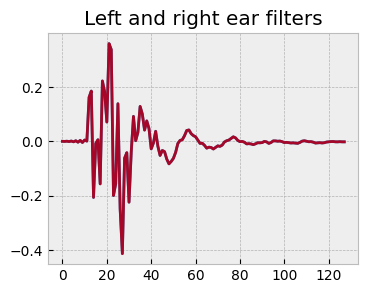

In [27]:
# Straight ahead
hrtf_crumble = hrtf(input_sound_crumble, 0, 0)
sound(hrtf_crumble,
      rate=fs_crumble,
      label=f"{fname_crumble} HRTF straight ahead")

if not SUBMISSION_MODE:
    hrtf_fly = hrtf(input_sound_fly, 0, 0)
    sound(hrtf_fly, rate=fs_fly, label=f"{fname_fly} HRTF straight ahead")

    hrtf_heli = hrtf(input_sound_heli, 0, 0)
    sound(hrtf_heli, rate=fs_heli, label=f"{fname_heli} HRTF straight ahead")

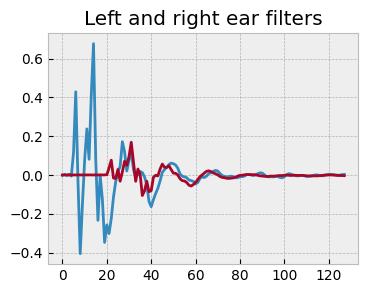

In [28]:
# 45° to the left
hrtf_crumble = hrtf(input_sound_crumble, -45, 0)
sound(hrtf_crumble, rate=fs_crumble, label=f"{fname_crumble} HRTF 45° left")

if not SUBMISSION_MODE:
    hrtf_fly = hrtf(input_sound_fly, -45, 0)
    sound(hrtf_fly, rate=fs_fly, label=f"{fname_fly} HRTF 45° left")

    hrtf_heli = hrtf(input_sound_heli, -45, 0)
    sound(hrtf_heli, rate=fs_heli, label=f"{fname_heli} HRTF 45° left")

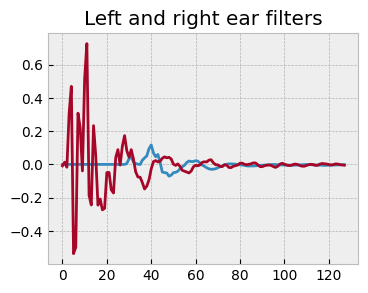

In [29]:
# 80° to the right
hrtf_crumble = hrtf(input_sound_crumble, 80, 0)
sound(hrtf_crumble, rate=fs_crumble, label=f"{fname_crumble} HRTF 80° right")

if not SUBMISSION_MODE:
    hrtf_fly = hrtf(input_sound_fly, 80, 0)
    sound(hrtf_fly, rate=fs_fly, label=f"{fname_fly} HRTF 80° right")

    hrtf_heli = hrtf(input_sound_heli, 80, 0)
    sound(hrtf_heli, rate=fs_heli, label=f"{fname_heli} HRTF 80° right")

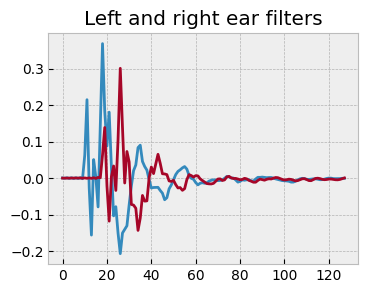

In [30]:
#160° to the left
hrtf_crumble = hrtf(input_sound_crumble, -160, 0)
sound(hrtf_crumble, rate=fs_crumble, label=f"{fname_crumble} HRTF 160° left")

if not SUBMISSION_MODE:
    hrtf_fly = hrtf(input_sound_fly, -160, 0)
    sound(hrtf_fly, rate=fs_fly, label=f"{fname_fly} HRTF 160° left")

    hrtf_heli = hrtf(input_sound_heli, -160, 0)
    sound(hrtf_heli, rate=fs_heli, label=f"{fname_heli} HRTF 160° left")

### Conclusions
While experimenting with the HRTF filters, I was surprised when I found the straight ahead sound felt a little less prominent in the lower frequencies as compared to both the original sound as well as the filters designed in part 1. This made the sound a little thinner than its counterparts. When I was listening to the sounds (HRTF) positioned in locations other than straight ahead, I felt like the sense of space was a lot more believable than through the filters in part 1. This is not to discredit the filters designed in part 1 as they too sounded quite believable as if they were in different locations.

## Part 3. Dynamic Sources with HRTFs

In this part you will need to make a moving sound source. In order to do so we will make use of a fast convolution routine based on your STFT code from lab 1 (ha, you thought you were done with that!). In order to perform fast convolution we can perform an STFT of the sound to use, multiply each time frame of this transform with the DFT of the filter that we want  to impose and then use overlap add to transform back to the time domain.

Start by taking each sound from above, and apply your STFT on it. Make sure that the size of the transform is the same as the HRTF’s filter length. The hop size should be the same as the DFT size and you will need to zero pad by as much as the DFT size in order to facilitate the tail of the convolution. Do not use an analysis/synthesis window.

Once you compute this STFT, go through its every time frame and element-wise multiply it with the desired HRTF filter to generate the STFT of the left and right sounds. Figure out which HRTF angle to multiply each frame with so that by the end of the sound you will have made it go around your head.

Once you perform these operations you will have generated two STFT matrices, one for the left channel and one for the right. Use your inverse STFT routine and play the stereo sound through your headphones. You should hear a convincing rendering of the original sounds circling around your head.

Submit only one of the sounds, but make sure you try it on all and that it sounds ok.

In [31]:
# STFT and ISTFT from lab 1
def stft(input_sound, dft_size, hop_size, zero_pad, window):
    # Creating the n-1 frames
    frames = []
    idx = 0
    for idx in range(0, len(input_sound) - dft_size, hop_size):
        frames.append(np.multiply(input_sound[idx:idx + dft_size], window))
    idx += hop_size

    # Creating the last frame accounting for padding
    last_frame = np.multiply(
        np.append(input_sound[idx:-1],
                  np.zeros(idx + dft_size - len(input_sound) + 1)), window)
    frames.append(last_frame)

    # Convert to numpy array
    frames = np.array(frames, dtype=float)

    # Compute the DFT of each frame
    dft_frames = np.fft.rfft(frames, dft_size + zero_pad)
    return dft_frames


def istft(stft_output, dft_size, hop_size, zero_pad):
    # Initializing the signal length
    signal_length = (stft_output.shape[0] * hop_size) + dft_size + zero_pad
    signal = np.zeros(signal_length)

    for i in range(stft_output.shape[0]):
        original_signal = np.fft.irfft(stft_output[i, :], dft_size + zero_pad)
        start = i * hop_size
        end = start + original_signal.shape[0]
        signal[start:end] += original_signal

    return signal

In [32]:
# Making a 360° sound
def make_360(input_sound, dft_size, hop_size, zero_pad, window):
    input_sound_stft = stft(input_sound, dft_size, hop_size, zero_pad, window)

    # Making sure the the size of the transform is the same as the HRTF’s filter length
    left_chan = np.zeros(input_sound_stft.shape, dtype=complex)
    right_chan = np.zeros(input_sound_stft.shape, dtype=complex)

    for i in range(input_sound_stft.shape[0]):
        azimuth = (i / input_sound_stft.shape[0]) * 360
        left_filter, right_filter = hrtf_filter(
            azimuth, 0)  # Choose the appropriate filter

        # Applying a fft to the filter
        left_chan[i] = input_sound_stft[i] * np.fft.rfft(
            left_filter, dft_size * 2)
        right_chan[i] = input_sound_stft[i] * np.fft.rfft(
            right_filter, dft_size * 2)

    # Inverse STFT routine
    left_chan = istft(left_chan, dft_size, hop_size, zero_pad)
    right_chan = istft(right_chan, dft_size, hop_size, zero_pad)

    return np.vstack((left_chan, right_chan))


dft_size = 256
hop_size = dft_size
zero_pad = dft_size
window = 1

crumble_360 = make_360(input_sound_crumble, dft_size, hop_size, zero_pad,
                       window)
sound(crumble_360, rate=fs_crumble, label=f"{fname_crumble} 360° effect")

if not SUBMISSION_MODE:
    fly_360 = make_360(input_sound_fly, dft_size, hop_size, zero_pad, window)
    sound(fly_360, rate=fs_fly, label=f"{fname_fly} 360° effect")

    heli_360 = make_360(input_sound_heli, dft_size, hop_size, zero_pad, window)
    sound(heli_360, rate=fs_heli, label=f"{fname_heli} 360° effect")

## Part 4. Extra credit (required for 4-hour credit registrants)

Use the file in [https://drive.google.com/uc?export=download&id=1bxQkXcGa57S3G7IRWu9urS-jCPdf5Pif ] to make a short story. This is a 7-channel file of a scene from a really bad B-movie. Each channel contains a different sound. If you play that sound you probably won’t hear most of the content since you won’t have a 7 speaker setup, import it in a multi-channel editor such as Audacity and you will get a sense of what’s in there. Since it sounds so boring you need to add some reverb and 3D-locate the sounds so that it sounds more exciting. Try to make it sound better using what we have done so far. Keep in mind that you can add different amounts of reverb for each sound, and you can dynamically 3D place them as well.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()